In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 500
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 150,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    print("Pretrained model loaded")
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
else:
    print("Loaded empty model")
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon, and a dragon-eating dragon.

I'm a dragon, and a dragon-eating dragon.

(I'm a dragon, and a dragon-eating dragon.

(I'm a dragon, and a dragon-eating dragon.

(I'm a dragon, and a dragon-eating dragon.

(I'm a dragon, and a dragon-eating dragon.

(I'm a dragon, and a dragon-eating dragon.

(I'm a dragon, and a dragon-eating dragon.

(I'm a dragon,


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [7]:
train_results = {}
model.train()
train_model(model, tokenizer, config, train_results)

  0%|          | 0/2 [00:00<?, ?it/s]

/opt/awsw/model_utils.py:119: FutureWarning: disable_progress_bar is deprecated and will be removed in the next major version of datasets. Use set_progress_bar_enabled(False) instead.
  datasets.utils.disable_progress_bar()


Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors


<p><msg>c "You already told me about the four-headed human, so I think I can handle this."<|endoftext|><d><scn>black<msg>Br "Wait for you to... t-throw up so I win?"<|endoftext|><d><scn>buildingoutside<msg>Ry "Okay, someone else dropped it."<|endoftext|><d><scn>cafe<msg>n "Despite all odds, I managed to match her perfect score in the game we played."<|endoftext|><p><msg>c "I'd love to, but I can't promise I won't have other obligations
 at the time."<|endoftext|><d><scn>np1r<msg>m "The Administrator had told me all about the prowess of the generators within. It probably hadn't been hard for Reza to guess the same, or to try stealing it from a place he knew would be even more deserted than the rest of the village was right now."<|endoftext|><d><scn>loremapt<msg>Lo "If humans wear clothes like this, it's only appropriate to depict them as such."<|endoftext|><d><scn>black<msg>Lo "I don't know, exactly. The counter on my
[0] set freeze_part_layers: True (freezing 150 out of 160 layers.)


Step,Training Loss
540,2.502000
1080,2.127700
1620,2.074800
2160,2.049900
2700,2.034200
3240,2.021400
3780,2.012800
4320,2.003100
4860,2.000500
5400,1.996000


AttributeError: module 'torch.cuda' has no attribute 'empty_cafche'

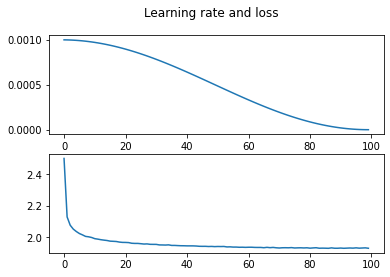

In [8]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [9]:
model.eval()
test_regular_sampler()

In my dreams, I'm a dragon. I was born here in the first place when I was only a little more than a baby. I still have nightmares about my father, and I don't know why."<d><scn>loremapt<msg>Lo "When I was a baby, I didn't have a birth plan. I was just a baby, and I didn't want to do that. It's just a thing."<d><scn>loremapt<msg>Lo "You're not just a baby. You've been given the right to grow up here."<d><sc


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [11]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park2<msg>Ry "I'm good."<d><scn>park


Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "I think he's just a little shy."<p><msg>c "I'm not shy."<d><scn>park2<msg>Ad "I'm not shy."<p><msg>c "I'm not shy."<p><msg>c "I'm not shy."<p><msg>c "


Prompt: Oh my god, Adine. What is this?
Reply: facin2<msg>An "I'm not sure, but I'm not sure if it's a good idea to go to the park, or if I'm just going to sit there and wait for Adine to come back, or if I'm just going to wait for Adine to come back."<p><msg>c "I'm not sure if it's a good idea to go to the park


Prompt: What will we do here?
Reply: park2<msg>Ry "I'll see you."<p><msg>c "I'll see you."<d><scn>park2<msg>Ry "I'll see you."<|endoftext|>




# Sampling test

This is gonna be interesting!

In [12]:
for i in range(10):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1] -> Prompt: How are you?
Reply: park2<msg>Ry "Hey, how are you?"<|endoftext|>

[Test 1] -> Prompt: What do you think of Lorem?
Reply: park2<msg>Ad "Oh, I think Lorem has something to prove."<p><msg>c "I don't know. But I think I can find a lot of ways to help others. I think we need to be patient, too."<d><scn>park2<msg>Ad "Do you have any ideas?"<p><msg

[Test 1] -> Prompt: Oh my god, Adine. What is this?
Reply: np2x<msg>Ad "And now, after a few moments, I'm sure we'll have plenty of time for you, then."<d><scn>np2x<msg>m "I watched the proceedings closely."<p><msg>c "Adine."<d><scn>np2x<msg>Ad "Adine, what are you talking about?"<p

[Test 1] -> Prompt: What will we do here?
Reply: np2<msg>Ad "Well, I'll do what I can, but I'm not sure how much."<p><msg>c "We could use some help, right?"<d><scn>np2<msg>Ad "What do you want me to do?"<p><msg>c "If we find something, we'll be able to do some work on it."<p><msg>c "You

-------------
[Test 2] -> Prompt: How are you?
Reply: park2<

# RP test
Testing out the injected roleplay actions

In [19]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')

Visit Lorem -> facin2<msg>Lo "Hey, I just got back from my trip with my kids and the news that they have been expelled from the university. I'm going to give them a real first impression, since I know they're not as lucky as they say."<|endoftext|>
Meet with Lorem -> facin2<msg>Lo "Hi, [player_name]. I'm Lorem, from the sound of things."<|endoftext|>
Visit Adine -> facin2<msg>An "Oh, and you can just look me up at the top of my head."<|endoftext|>
Fight Maverick -> loremapt<msg>m "He made his first foray into the dark."<|endoftext|>
Fight Adine -> emeraroom<msg>Em "You're the most important person in the universe."<d><scn>emeraroom<msg>Em "You're the most important person in the universe, right?"<|endoftext|>
